###### *Importing Libraries*

In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

###### *Download and view head of data table*

In [2]:
#import data (10 year time frame)
commodity_data = yf.download('GC=F', start='2012-10-10', end='2022-10-10')
commodity_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-10-09,1776.699951,1776.699951,1762.300049,1763.000000,1763.000000,24
2012-10-10,1762.400024,1764.199951,1758.099976,1763.199951,1763.199951,29
2012-10-11,1761.599976,1771.000000,1761.599976,1768.800049,1768.800049,30
2012-10-12,1769.500000,1769.500000,1753.599976,1758.000000,1758.000000,84
2012-10-15,1750.000000,1750.000000,1729.900024,1736.000000,1736.000000,108


###### *Cleaning data to remove any null values*

In [3]:
print(commodity_data.isnull().sum()) #check how many null values are in out dataset
commodity_data.dropna(inplace=True)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


###### *Plotting the closing price graph of the commodity*

Text(0, 0.5, 'Prices ($)')

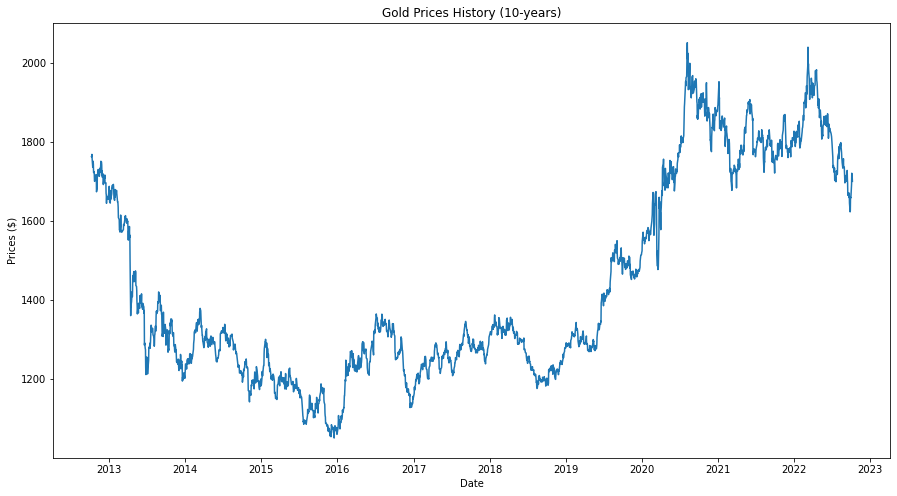

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Gold Prices History (10-years)')
plt.plot(commodity_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [5]:
close_prices = commodity_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8) #take 80% of the total data as training data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1)) #Scale the prices between (-1, 1) to avoid intensive computation

train_data = scaled_data[0: training_data_len, :]

###### *Structuring the data for training purpose (Not Rolling window)*
The model will use the previous 60 days as the deciding factor and will predict the opening price for 61st day.

In [6]:
# x_train = [] #will be the inputs for training set
# y_train = [] #is the output for training set
# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i, 0])
#     y_train.append(train_data[i, 0])

# #X_train is a nested list, which contains lists of 60 time-stamp prices. 
# #y_train is a list of stock prices which is the next day stock price, corresponding to each list in X_train
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# test_data = scaled_data[training_data_len-60: , : ]
# x_test = []
# y_test = values[training_data_len:]

# for i in range(60, len(test_data)):
#     x_test.append(test_data[i-60:i, 0])

# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

###### Structuring the data: Rolling window 

In [7]:
# Setting the window size (in this case, we'll use 7 days for a weekly prediction)
window_size = 7

# Initialize empty lists to store the training and test sets
x_train, y_train, x_test, y_test = [], [], [], []

# Iterate over the data
for i in range(len(scaled_data) - window_size):
    # Get the data for the current window
    x = scaled_data[i:i+window_size, 0]
    y = scaled_data[i+window_size, 0]

    # Split the data into training and test sets
    if i < training_data_len - window_size:
        x_train.append(x)
        y_train.append(y)
    else:
        x_test.append(x)
        y_test.append(y)

# Convert the lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the data for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [8]:
print("x_train size and shape: {}".format(x_train.shape))
print("y_train size and shape: {}".format(y_train.shape))
print("x_test size and shape: {}".format(x_test.shape))
print("y_test size and shape: {}".format(y_test.shape))

x_train size and shape: (2005, 7, 1)
y_train size and shape: (2005,)
x_test size and shape: (502, 7, 1)
y_test size and shape: (502,)


###### *Creating our Model:*

In [9]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.2)) # Add dropout with a rate of 0.2
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dropout(0.2)) # Add dropout with a rate of 0.2
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error') #optimizer and loss
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trai

In a neural network, dropout is a regularization technique that helps prevent overfitting by randomly dropping out (i.e., setting to zero) a certain fraction of the neurons in the network during training. This has the effect of reducing the capacity of the network and forcing it to learn multiple independent representations of the data, which can improve generalization to unseen data. In this example, dropout is added after the first and second LSTM layers, with a rate of 0.2 (i.e., 20% of the neurons will be dropped out during training). You can adjust the rate to control the amount of dropout applied to the model. A higher rate will result in more dropout and a lower capacity model, while a lower rate will result in less dropout and a higher capacity model.<br>
<br>
In a neural network, a dense layer (also known as a fully-connected layer) is a layer that performs a linear transformation on the input data using a set of weights and biases. Each neuron in a dense layer receives input from all the neurons in the previous layer and produces an output that is passed to all the neurons in the next layer. In my code, the dense layer has 25 neurons and is added after the second LSTM layer. The output of this layer is passed to the next layer, which is a single neuron dense layer that produces the final output of the model.
<br>
<br>

###### *Training the model*

In [10]:
model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
63/63 [==============================] - 3s 7ms/step - loss: 0.0095
Epoch 2/50
63/63 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 3/50
63/63 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 4/50
63/63 [==============================] - 0s 7ms/step - loss: 9.7622e-04
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 6/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 7/50
63/63 [==============================] - 0s 8ms/step - loss: 9.9154e-04
Epoch 8/50
63/63 [==============================] - 0s 8ms/step - loss: 7.6413e-04
Epoch 9/50
63/63 [==============================] - 0s 7ms/step - loss: 8.3074e-04
Epoch 10/50
63/63 [==============================] - 0s 7ms/step - loss: 9.0144e-04
Epoch 11/50
63/63 [==============================] - 0s 7ms/step - loss: 8.4632e-04
Epoch 12/50
63/63 [==============================] - 0s 7ms/step - loss: 7.9976e-04
Epoch 13/50
63/63 [==

In [11]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #inverse scaling
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)) #inverse scaling

16/16 [==============================] - 1s 2ms/step


In [12]:
y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))
#print(np.array_equal(loss.numpy(), np.mean(np.square(y_test - predictions), axis=-1)))

C:\Users\Israh\AppData\Local\Temp\ipykernel_12192\3337659789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


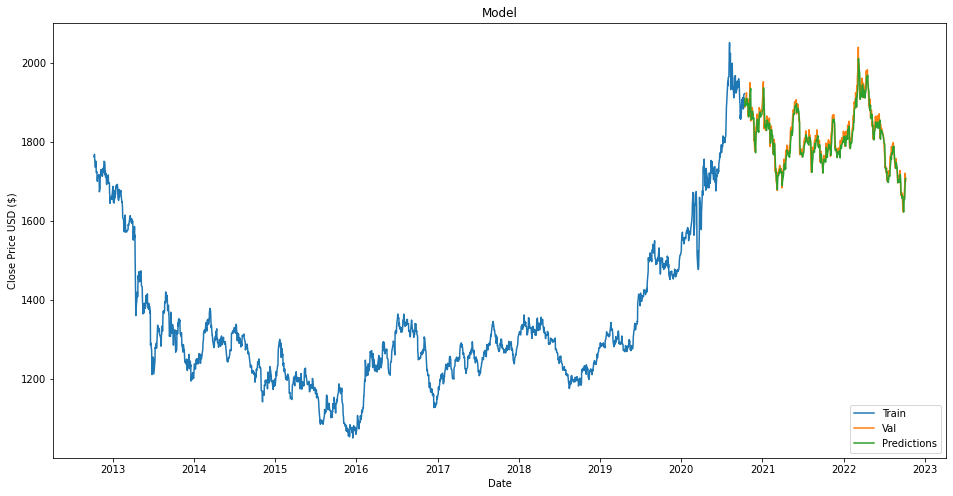

In [13]:
data = commodity_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

###### *Metrics of our model predictions*

In [14]:
from metrics import *
y_test = np.array(y_test) # convert y_test to a numpy array
y_test = y_test.reshape(-1, 1) # reshape y_test to a one-dimensional array
print(f'r2  : {R2(predictions, y_test):.3F}')
print(f'rse : {RSE(predictions, y_test):.3F}')
print(f'mae : {MAE(predictions, y_test):.3F}')
print(f'mse : {MSE(predictions, y_test):.3F}')
print(f'rmse: {RMSE(predictions, y_test):.3F}')
print(f'mape: {MAPE(predictions, y_test):.3F}')
print(f'mspe: {MSPE(predictions, y_test):.7F}')

r2  : 0.923
rse : 0.277
mae : 15.007
mse : 382.424
rmse: 19.556
mape: 0.008
mspe: 0.0001142


*References*
<br>
[1] https://heartbeat.comet.ml/a-beginners-guide-to-implementing-long-short-term-memory-networks-lstm-eb7a2ff09a27